In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Create random dataset

In [2]:
# 1 - list layers to transform dataset
transform = transforms.Compose([
    transforms.ToTensor(), # transform uint8 to tensor
    transforms.Normalize(0.5, 0.5) # normalize the pixels
])

In [3]:
# 2 - download the mnist dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True) # for training
val_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True) # for validation

In [4]:
# 3 - load dataset into packages
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # package the dataset into 64 packages and shuffle it
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) # the same with train_loader, without shuffle

# Create model and its hyperparameters

In [5]:
# 1 - cnn model class
class CNNModel(nn.Module):
    def __init__(self): # model layers structure
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) # conv1 mask
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # conv2 mask
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # pooling mask
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # conv3 mask
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) # conv4 mask
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # pooling mask
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # fully linear layer
        self.fc2 = nn.Linear(128, 10) # fully linear layer
        self.relu = nn.ReLU() # activation layer
    def forward(self, x): # model data flow controls
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7) # reshape the data into flatten 1d
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# 2 - instantiate the model, loss and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and Valid

In [7]:
# 1 - train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # if gpu is available move model to it
epochs = 5
for epoch in range(epochs):
    model.train() # enter the model into training mode
    running_loss = 0.0
    for images, labels in train_loader: # enter the train loader
        images, labels = images.to(device), labels.to(device) # if gpu is available move images and labels to it
        preds = model(images) # model predictions
        loss = criterion(preds, labels) # calculate the error
        optimizer.zero_grad() # cleaning the previous gradient
        loss.backward() # jump to the backward
        optimizer.step() # and improve the model with backward
        running_loss += loss.item() # register the losses
    print(f"epoch {epoch}, loss: {running_loss}") # print out each epoch loss

epoch 0, loss: 160.0640359185636
epoch 1, loss: 40.05339048654423
epoch 2, loss: 28.077032206609147
epoch 3, loss: 21.980355236231844
epoch 4, loss: 16.341470628576644


In [8]:
# 2 - valid the model
model.eval() # enter the model into validation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device) # again move the val_dataset into gpu
        preds = model(images) # get model predictions
        _, predicts = torch.max(preds, 1) # extract only the predictions essential
        correct += (predicts == labels).sum().item() # and sum the correct answer
        total += labels.size(0) # sum up total images quantity
    print(f"for the total {total}, we got {correct} correct answer")

for the total 10000, we got 9921 correct answer


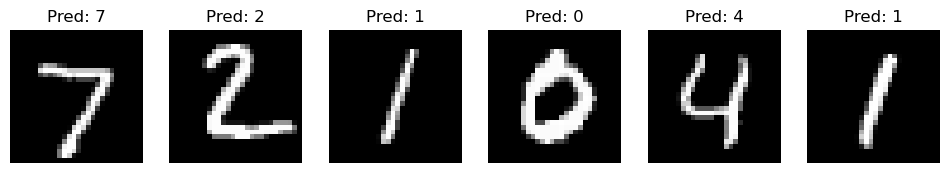

In [9]:
# 3 - visualize the validation predictions
examples = iter(val_loader) # iterate the validation loader
images, labels = next(examples) # getting images and labels by the iter
images, labels = images.to(device), labels.to(device) # moving images and labels to gpu
with torch.no_grad(): # disable gradient
    preds = model(images) # getting model predictions
    w, preds_label = torch.max(preds, 1) # getting model predictions labels
    #print(nn.functional.softmax(preds, dim=0))
fig, axes = plt.subplots(1, 6, figsize=(12, 4)) # 1 row 6 columns
for i in range(6):
    axes[i].imshow(images[i].cpu().squeeze(), cmap="gray") # convert image to gray scale
    axes[i].set_title(f"Pred: {preds_label[i].item()}") # title each image
    axes[i].axis("off") # hide axis ticks and labels to make image more cleaner
plt.show()